In [1]:


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
import numpy as np
import gym


In [2]:
# create the cartpole environment from the gym library
#  
train_env = gym.make('CartPole-v1')
test_env = gym.make('CartPole-v1')

/Users/friedrichwilkegrosche/miniforge3/envs/hivemind/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [4]:
# seed the random number generators for reproducibility

SEED = 1234

train_env.reset(seed = SEED)
test_env.reset(seed=SEED+1)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [5]:
# Multilayer Perceptron (MLP) model that implements the Agent's Policy
# Contains 2 hidden layers and a dropout layer

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super().__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc_2(x)
        return x


In [6]:
# define the input and output dimensions of the network
# and create the policy network

INPUT_DIM = train_env.observation_space.shape[0]
HIDDEN_DIM = 128
OUTPUT_DIM = train_env.action_space.n

policy = MLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)


In [7]:
# initialize the weights of the policy network
# we use the xavier initialization method which is described in 
# 'Understanding the difficulty of training deep feedforward
# neural networks' - Glorot, X. & Bengio, Y. (Equation: 1)
# the starting weights are drawn from N(0, std^2) where std = gain \times \sqrt(2/(fan_in + fan_out))
# fan_in = number of input units
# fan_out = number of output units

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)


policy.apply(init_weights)


In [13]:
# set a learning rate and the optimiser for the policy network

LEARNING_RATE = 0.01

optimizer = optim.Adam(policy.parameters(), lr=LEARNING_RATE)


In [14]:
# train the network


def train(env, policy, optimizer, discount_factor):

    policy.train()

    log_prob_actions = []
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)

        action_pred = policy(state)

        action_prob = F.softmax(action_pred, dim=-1)

        dist = distributions.Categorical(action_prob)

        action = dist.sample()

        log_prob_action = dist.log_prob(action)

        state, reward, done, _ = env.step(action.item())

        log_prob_actions.append(log_prob_action)
        rewards.append(reward)

        episode_reward += reward

    log_prob_actions = torch.cat(log_prob_actions)

    returns = calculate_returns(rewards, discount_factor)

    loss = update_policy(returns, log_prob_actions, optimizer)

    return loss, episode_reward


In [15]:
#

def calculate_returns(rewards, discount_factor, normalize=True):

    returns = []
    R = 0

    for r in reversed(rewards):
        R = r + R * discount_factor
        returns.insert(0, R)

    returns = torch.tensor(returns)

    if normalize:
        returns = (returns - returns.mean()) / returns.std()

    return returns


In [16]:
def update_policy(returns, log_prob_actions, optimizer):

    returns = returns.detach()

    loss = - (returns * log_prob_actions).sum()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    return loss.item()


In [17]:
def evaluate(env, policy):

    policy.eval()

    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)

        with torch.no_grad():

            action_pred = policy(state)

            action_prob = F.softmax(action_pred, dim=-1)

        action = torch.argmax(action_prob, dim=-1)

        state, reward, done, _ = env.step(action.item())

        episode_reward += reward

    return episode_reward


In [18]:
MAX_EPISODES = 500
DISCOUNT_FACTOR = 0.99
N_TRIALS = 25
REWARD_THRESHOLD = 475
PRINT_EVERY = 10

train_rewards = []
test_rewards = []

for episode in range(1, MAX_EPISODES+1):

    loss, train_reward = train(train_env, policy, optimizer, DISCOUNT_FACTOR)

    test_reward = evaluate(test_env, policy)

    train_rewards.append(train_reward)
    test_rewards.append(test_reward)

    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])

    if episode % PRINT_EVERY == 0:

        print(
            f'| Episode: {episode:3} | Mean Train Rewards: {mean_train_rewards:5.1f} | Mean Test Rewards: {mean_test_rewards:5.1f} |')

    if mean_test_rewards >= REWARD_THRESHOLD:

        print(f'Reached reward threshold in {episode} episodes')

        break


| Episode:  10 | Mean Train Rewards:  15.1 | Mean Test Rewards:   9.7 |
| Episode:  20 | Mean Train Rewards:  13.7 | Mean Test Rewards:   9.3 |
| Episode:  30 | Mean Train Rewards:  11.8 | Mean Test Rewards:   9.2 |
| Episode:  40 | Mean Train Rewards:  11.6 | Mean Test Rewards:   9.2 |
| Episode:  50 | Mean Train Rewards:  12.8 | Mean Test Rewards:   9.3 |
| Episode:  60 | Mean Train Rewards:  14.7 | Mean Test Rewards:   9.5 |
| Episode:  70 | Mean Train Rewards:  21.2 | Mean Test Rewards:  19.8 |
| Episode:  80 | Mean Train Rewards:  38.8 | Mean Test Rewards: 149.3 |
| Episode:  90 | Mean Train Rewards:  57.1 | Mean Test Rewards: 247.1 |
| Episode: 100 | Mean Train Rewards:  79.6 | Mean Test Rewards: 235.9 |
| Episode: 110 | Mean Train Rewards:  96.7 | Mean Test Rewards: 210.3 |
| Episode: 120 | Mean Train Rewards: 136.5 | Mean Test Rewards: 298.3 |
| Episode: 130 | Mean Train Rewards: 160.8 | Mean Test Rewards: 437.2 |
Reached reward threshold in 133 episodes


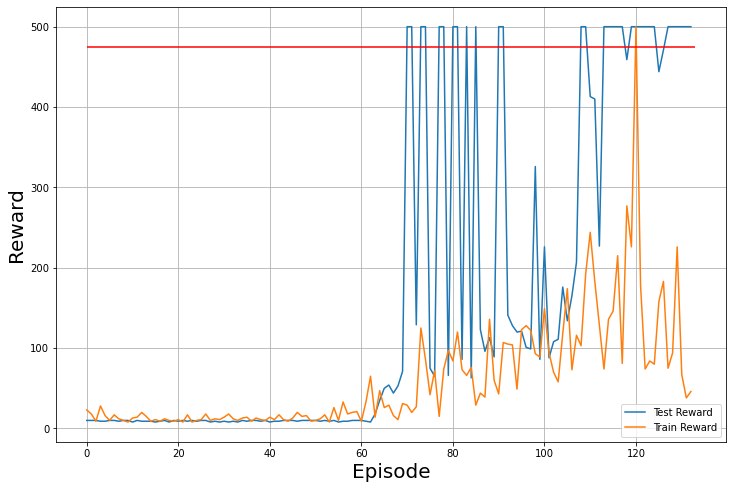

In [19]:


plt.figure(figsize=(12, 8))
plt.plot(test_rewards, label='Test Reward')
plt.plot(train_rewards, label='Train Reward')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.hlines(REWARD_THRESHOLD, 0, len(test_rewards), color='r')
plt.legend(loc='lower right')
plt.grid()
